**Requirements**
1. **Data preprocessing:** You must handle large datasets and perform necessary data preprocessing tasks. This includes dealing with missing values, handling outliers, and scaling data appropriately for the chosen regression technique.

    a. Consider the appropriate intervals for wind speeds and wind directions. No negative wind speeds are allowed, and wind directions should be in an appropriate interval (e.g. [0; 360[ degrees).

    b. Select which ws / wd signals to use. Signals at higher altitude are generally better, but it is even more important to have proper coverage of all seasons.

    c. Find the meso-signals closest in height to the mast-data-signal you are using. Or interpolate the values between 2 or more meso-signals to get the values at the exact mast-signal-height.

    d. Convert the mast data from DK time to UTC time (corresponding to the time zone used in the meso data). Remember to account for summer-time in DK.
    
    e. Resample the mast dataset to have the same frequency as the meso data. The meso data has one record for each hour, the mast data has one record for each 10 min.

        i. Note: You should not convert the ws / wd signals to vector-quantities and use those for the resampling. Resample the ws and wd signal individually instead. The turbines “yaw” to always point toward the incoming wind, so the interesting value is the wind speed and not the wind velocity.  
        ii. Be careful when resampling the wind directions. You don’t want the average of 0 degrees and 359 degrees to become ~180 degrees :-)

    f. Find the overlapping timestamps between the meso data and the resampled mast data. You only want to consider data in this overlapping time period in your training.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

In [90]:
#load the mast data
from datetime import datetime
filepath = r'Assignment 3\Data\Risoe\risoe_m_all.nc'
dataset = nc.Dataset(filepath, 'r')
df_mast = pd.DataFrame({
    'time': dataset.variables['time'][:],
    'ws77': dataset.variables['ws77'][:],
    'wd77': dataset.variables['wd77'][:]
})
base_date = datetime(1995, 11, 20, 16, 25, 0)

#convert time to datetime format
df_mast['time'] = pd.to_datetime(df_mast['time'], unit='m', origin=base_date)
df_mast

time  ws77   wd77
0      1995-11-20 16:25:00  3.36  205.0
1      1995-11-20 16:35:00  3.05  205.0
2      1995-11-20 16:45:00  3.59  204.0
3      1995-11-20 16:55:00  3.87  202.0
4      1995-11-20 17:05:00  4.74  201.0
...                    ...   ...    ...
628354 2007-12-31 23:16:00  6.04    0.0
628355 2007-12-31 23:26:00  6.97    0.0
628356 2007-12-31 23:36:00  8.17    0.0
628357 2007-12-31 23:46:00  6.66    0.0
628358 2007-12-31 23:56:00  6.72    0.0

[628359 rows x 3 columns]

In [91]:
#load the meso data
filepath_meso = r'Assignment 3\Data\Risoe\meso_Risoe.csv'
df_meso = pd.read_csv(filepath_meso)

#leave only the TIMESTAMP, WSP080, WDIR080 columns
df_meso = df_meso[['TIMESTAMP', 'WSP080', 'WDIR080']]
df_meso['TIMESTAMP'] = pd.to_datetime(df_meso['TIMESTAMP'])
df_meso

TIMESTAMP  WSP080  WDIR080
0      2001-06-10 15:00:00    1.77    94.47
1      2001-06-10 16:00:00    0.38   158.45
2      2001-06-10 17:00:00    0.93   313.49
3      2001-06-10 18:00:00    1.60   357.14
4      2001-06-10 19:00:00    5.50    19.64
...                    ...     ...      ...
204283 2020-09-24 08:00:00    9.30   214.93
204284 2020-09-24 09:00:00    9.47   213.96
204285 2020-09-24 10:00:00    8.84   229.81
204286 2020-09-24 11:00:00    8.82   232.81
204287 2020-09-24 12:00:00    7.20   242.28

[204288 rows x 3 columns]

In [92]:
#Convert the mast data from DK time to UTC time (corresponding to the time zone used in the meso data). If the date is between Mar 26 and Oct 29, subtract 2 hours. Otherwise, subtract 1 hour.
df_mast['time'] = df_mast['time'].apply(lambda x: x - pd.DateOffset(hours=2) if x.month > 3 and x.month <= 11 else x - pd.DateOffset(hours=1))
df_mast

time  ws77   wd77
0      1995-11-20 14:25:00  3.36  205.0
1      1995-11-20 14:35:00  3.05  205.0
2      1995-11-20 14:45:00  3.59  204.0
3      1995-11-20 14:55:00  3.87  202.0
4      1995-11-20 15:05:00  4.74  201.0
...                    ...   ...    ...
628354 2007-12-31 22:16:00  6.04    0.0
628355 2007-12-31 22:26:00  6.97    0.0
628356 2007-12-31 22:36:00  8.17    0.0
628357 2007-12-31 22:46:00  6.66    0.0
628358 2007-12-31 22:56:00  6.72    0.0

[628359 rows x 3 columns]

In [93]:
#Resample the mast dataset to have the same frequency as the meso data. The meso data has one record for each hour, the mast data has one record for each 10 min.
import math

df_mast = df_mast.set_index('time')
df_mast = df_mast.dropna()
# Resample 'ws77' using mean
resampled_ws77 = df_mast['ws77'].resample('1H').mean()

# Define a custom aggregation function for 'wd77'
def circular_mean(values):
    radians = [val * (2 * math.pi / 360) for val in values]
    sines = [sum([math.sin(rad) for rad in radians])]
    cosines = [sum([math.cos(rad) for rad in radians])]
    mean_rad = math.atan2(sines[0], cosines[0])
    mean_deg = mean_rad * (360 / (2 * math.pi))
    return mean_deg if mean_deg >= 0 else mean_deg + 360

# Resample 'wd77' using the custom aggregation function
resampled_wd77 = df_mast['wd77'].resample('1H').apply(circular_mean)

# Combine the resampled data into a new DataFrame
resampled_mast = pd.DataFrame({'ws77': resampled_ws77, 'wd77': resampled_wd77})

resampled_mast

ws77        wd77
time                                     
1995-11-20 14:00:00  3.467500  204.000076
1995-11-20 15:00:00  5.216667  201.003152
1995-11-20 16:00:00  6.288333  202.833228
1995-11-20 17:00:00  7.316667  200.166908
1995-11-20 18:00:00  7.943333  197.500508
...                       ...         ...
2007-12-31 18:00:00  6.366667    0.000000
2007-12-31 19:00:00  8.723333    0.000000
2007-12-31 20:00:00  8.430000    0.000000
2007-12-31 21:00:00  8.136667    0.000000
2007-12-31 22:00:00  6.966667    0.000000

[106185 rows x 2 columns]

In [94]:
# #join the datasets on an overlapping time period
df_joined = resampled_mast.join(df_meso.set_index('TIMESTAMP'), how='inner')
df_joined

ws77        wd77  WSP080  WDIR080
2000-01-01 07:00:00  6.573333  183.502033    5.83   209.09
2000-01-01 08:00:00  6.203333  194.212940    6.13   204.21
2000-01-01 09:00:00  6.701667  201.995414    6.69   204.75
2000-01-01 10:00:00  7.120000  196.499314    6.37   211.50
2000-01-01 11:00:00  6.541667  201.003968    6.20   217.37
...                       ...         ...     ...      ...
2007-12-31 18:00:00  6.366667    0.000000    6.43    11.71
2007-12-31 19:00:00  8.723333    0.000000    5.18    12.00
2007-12-31 20:00:00  8.430000    0.000000    4.98     6.64
2007-12-31 21:00:00  8.136667    0.000000    6.37     3.34
2007-12-31 22:00:00  6.966667    0.000000    6.90     9.16

[70072 rows x 4 columns]

In [95]:
#add the time column from index
df_joined['time'] = df_joined.index

#hot code encode time into 4 seasons
df_joined['spring'] = df_joined['time'].dt.month.between(3, 5, inclusive='both').astype(int)
df_joined['summer'] = df_joined['time'].dt.month.between(6, 8, inclusive='both').astype(int)
df_joined['fall'] = df_joined['time'].dt.month.between(9, 11, inclusive='both').astype(int)
df_joined['winter'] = ((df_joined['time'].dt.month >= 12) | (df_joined['time'].dt.month <= 2)).astype(int)
#drop the time column and missing values
df_joined = df_joined.drop(columns=['time'])
df_joined = df_joined.dropna()
df_joined.head()

ws77        wd77  WSP080  WDIR080  spring  summer  \
2000-01-01 07:00:00  6.573333  183.502033    5.83   209.09       0       0   
2000-01-01 08:00:00  6.203333  194.212940    6.13   204.21       0       0   
2000-01-01 09:00:00  6.701667  201.995414    6.69   204.75       0       0   
2000-01-01 10:00:00  7.120000  196.499314    6.37   211.50       0       0   
2000-01-01 11:00:00  6.541667  201.003968    6.20   217.37       0       0   

                     fall  winter  
2000-01-01 07:00:00     0       1  
2000-01-01 08:00:00     0       1  
2000-01-01 09:00:00     0       1  
2000-01-01 10:00:00     0       1  
2000-01-01 11:00:00     0       1

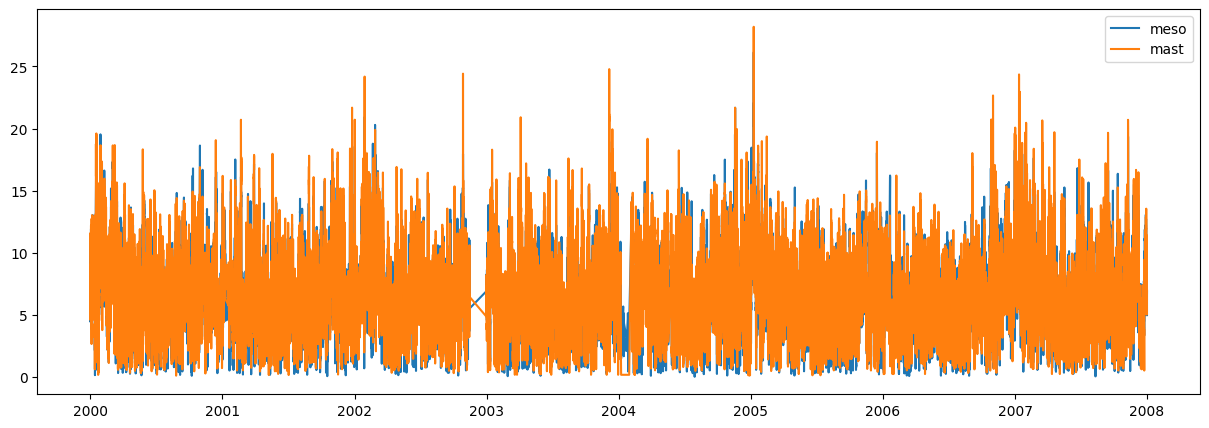

count    67641.000000
mean         6.861899
std          3.219878
min          0.130000
25%          4.585000
50%          6.594286
75%          8.748333
max         28.178333
Name: ws77, dtype: float64

In [96]:
#plot the data
plt.figure(figsize=(15, 5))
plt.plot(df_joined['WSP080'], label='meso')
plt.plot(df_joined['ws77'], label='mast')
plt.legend()
plt.show()
df_joined['ws77'].describe()

In [97]:
# #remove outliers using IQR
# Q1 = df_joined['WSP080'].quantile(0.25)
# Q3 = df_joined['WSP080'].quantile(0.75)
# IQR = Q3 - Q1
# df_joined = df_joined[~((df_joined['WSP080'] < (Q1 - 1.5 * IQR)) | (df_joined['WSP080'] > (Q3 + 1.5 * IQR)))]


# Q1 = df_joined['ws77'].quantile(0.25)
# Q3 = df_joined['ws77'].quantile(0.75)
# IQR = Q3 - Q1
# df_joined = df_joined[~((df_joined['ws77'] < (Q1 - 1.5 * IQR)) | (df_joined['ws77'] > (Q3 + 1.5 * IQR)))]
# df_joined['ws77'].describe()

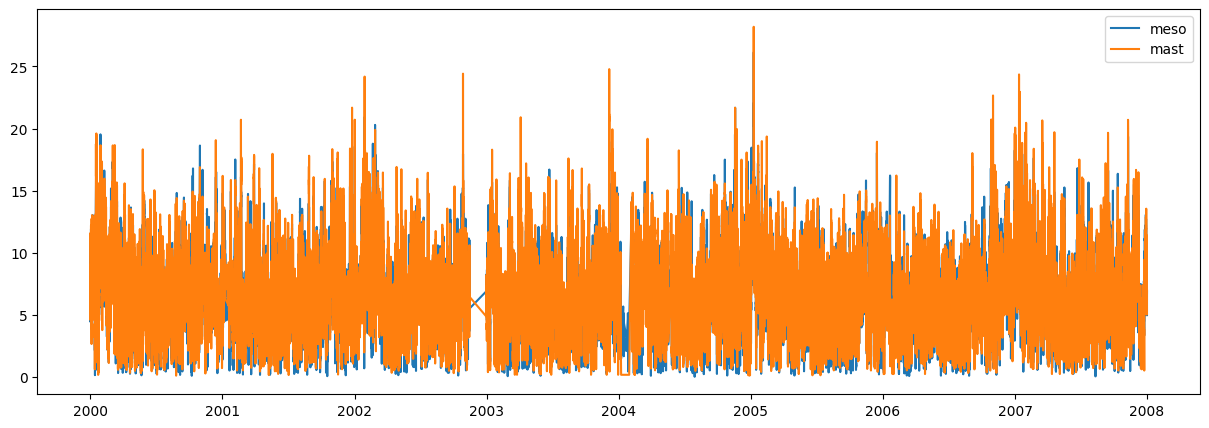

In [98]:
#plot the data
plt.figure(figsize=(15, 5))
plt.plot(df_joined['WSP080'], label='meso')
plt.plot(df_joined['ws77'], label='mast')
plt.legend()
plt.show()

In [99]:
#scale the wind speed data
from sklearn.preprocessing import MinMaxScaler
scaler_ws77 = MinMaxScaler()
df_joined['ws77'] = scaler_ws77.fit_transform(df_joined[['ws77']])

df_joined['wd77_sin'] = np.sin(np.radians(df_joined['wd77']))
df_joined['wd77_cos'] = np.cos(np.radians(df_joined['wd77']))

df_scaled = df_joined.drop(columns=['wd77'])
df_scaled.head()


ws77  WSP080  WDIR080  spring  summer  fall  winter  \
2000-01-01 07:00:00  0.229723    5.83   209.09       0       0     0       1   
2000-01-01 08:00:00  0.216531    6.13   204.21       0       0     0       1   
2000-01-01 09:00:00  0.234298    6.69   204.75       0       0     0       1   
2000-01-01 10:00:00  0.249213    6.37   211.50       0       0     0       1   
2000-01-01 11:00:00  0.228593    6.20   217.37       0       0     0       1   

                     wd77_sin  wd77_cos  
2000-01-01 07:00:00 -0.061084 -0.998133  
2000-01-01 08:00:00 -0.245526 -0.969390  
2000-01-01 09:00:00 -0.374532 -0.927214  
2000-01-01 10:00:00 -0.284004 -0.958823  
2000-01-01 11:00:00 -0.358433 -0.933556

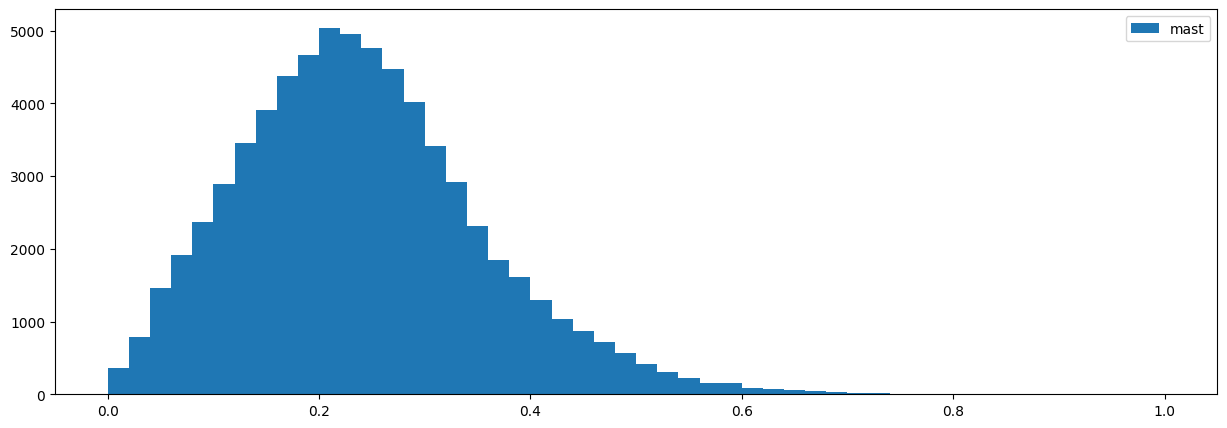

In [100]:
#plot histogram
plt.figure(figsize=(15, 5))
plt.hist(df_scaled['ws77'], bins=50, label='mast')
plt.legend()
plt.show()

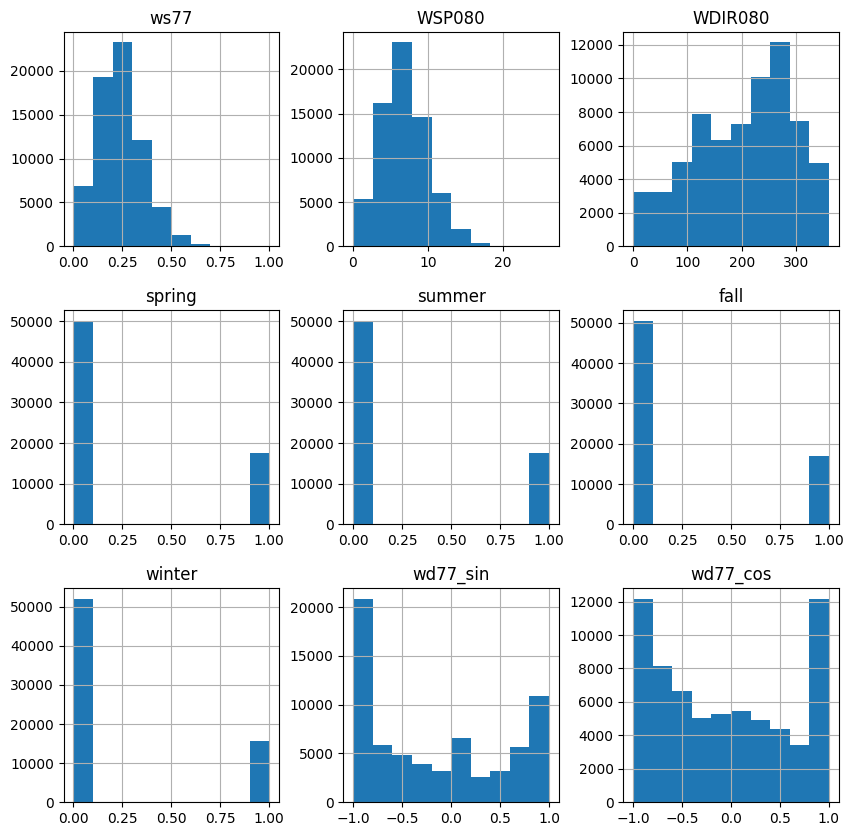

In [101]:
df_scaled.hist(figsize=(10,10))
plt.show()

In [102]:
from scipy.stats import weibull_min

def plot_weibull_distribution(data_column, num_bins=100):
    # Calculate the parameters of the Weibull distribution for the data
    shape, loc, scale = weibull_min.fit(data_column)

    # Generate values from the Weibull distribution
    x = np.linspace(0, data_column.max(), 100)
    weibull_values = weibull_min.pdf(x, shape, loc, scale)

    # Plot the histogram of the data
    plt.hist(data_column, bins=num_bins, density=True, alpha=0.5, label='Data')

    # Plot the Weibull distribution on the same plot
    plt.plot(x, weibull_values, 'r-', label='Weibull Distribution')

    # Add labels and legend
    plt.xlabel(data_column.name)
    plt.ylabel('Probability Density')
    plt.legend()

    # Show the plot
    plt.show()



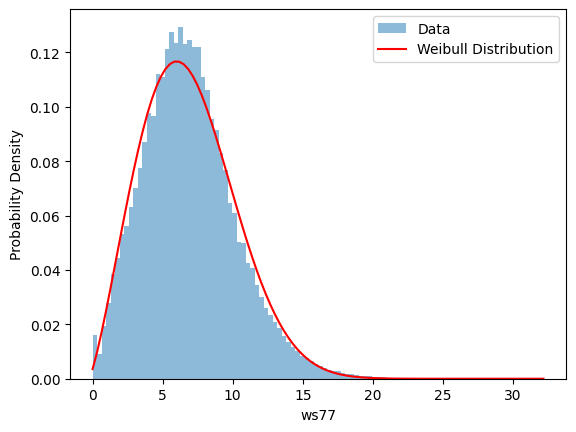

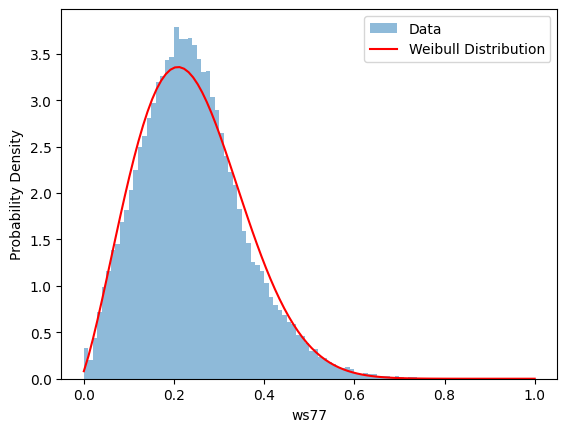

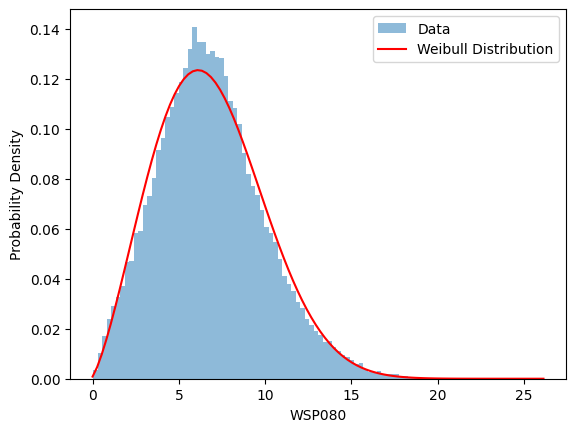

In [103]:
plot_weibull_distribution(df_mast['ws77'])
plot_weibull_distribution(df_scaled['ws77'])
plot_weibull_distribution(df_scaled['WSP080'])